In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_subject_levels

In [64]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')
df_c = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/hydrocortisone_Sim/hydrocortisone_Sim.csv')

In [65]:
df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
0,1,1,1,0.001,0.001,300,300,.,0,B,1,26,84
1,1,1,1,0.250,0.250,300,.,0,0,B,1,26,84
2,1,1,1,0.500,0.500,300,.,35.3,0,B,1,26,84
3,1,1,1,1.000,1.000,300,.,275,0,B,1,26,84
4,1,1,1,2.000,2.000,300,.,244,0,B,1,26,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,159,2,15,360.000,24.000,100,.,12.5,0,B,1,33,95
5217,159,2,15,372.000,36.000,100,.,5.36,0,B,1,33,95
5218,159,2,15,384.000,48.000,100,.,3.09,0,B,1,33,95
5219,159,2,15,408.000,72.000,100,.,1.97,0,B,1,33,95


In [66]:
df_c

,ID,TIME,AMT,DV
0,1.0,0.0,20000.0,0.00
1,1.0,0.5,0.0,281.28
2,1.0,1.0,0.0,368.22
3,1.0,2.0,0.0,304.77
4,1.0,3.0,0.0,186.59
...,...,...,...,...
275,20.0,8.0,0.0,59.32
276,20.0,9.0,0.0,46.33
277,20.0,10.0,0.0,35.61
278,20.0,11.0,0.0,29.10


In [67]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function

In [68]:
for c in df:
    df.loc[df[c] == '.', c] = pd.NA

In [69]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
remove_abs = True

if remove_abs:
    dfs = []
    for c in opt_df['SUBJID'].drop_duplicates():
        work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
        max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
        work_df = work_df.iloc[max_idx:, :]
        work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
        dfs.append(work_df.copy())
    work_df = pd.concat(dfs)
else:
    work_df = opt_df.copy()

In [70]:
work_df = work_df.loc[work_df['TIME'] < 30, :].copy()

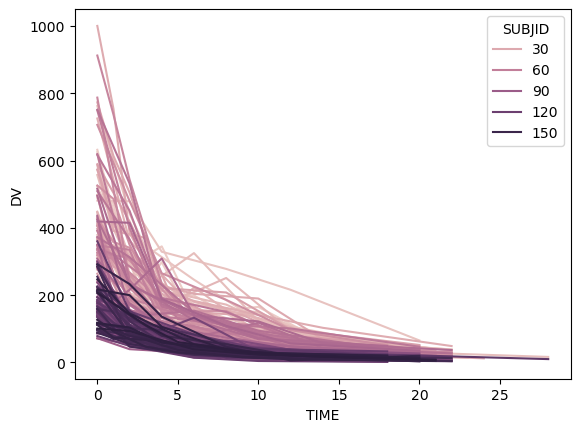

In [71]:
#plot the prepared data
plot_subject_levels(work_df)

In [72]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib

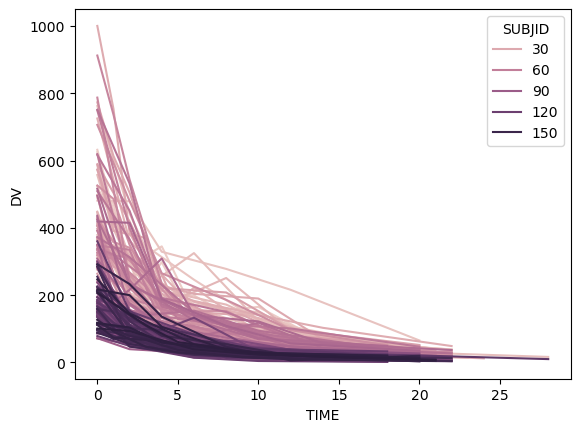

In [73]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
mgkg_scaler = RobustScaler()
age_scaler = RobustScaler()
wt_scaler = RobustScaler()

scale_df['MGKG'] = (scale_df['DOSR'] / scale_df['WT']) * 1000
scale_df['WT_scale'] = wt_scaler.fit_transform(scale_df[['WT']])
scale_df['MGKG_scale'] = mgkg_scaler.fit_transform(scale_df[['MGKG']])
scale_df['AGE_scale'] = age_scaler.fit_transform(scale_df[['AGE']])
#scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

In [74]:
scale_df['MGKG_round'] = scale_df['MGKG'].round(0)

<Axes: xlabel='TIME', ylabel='DV'>

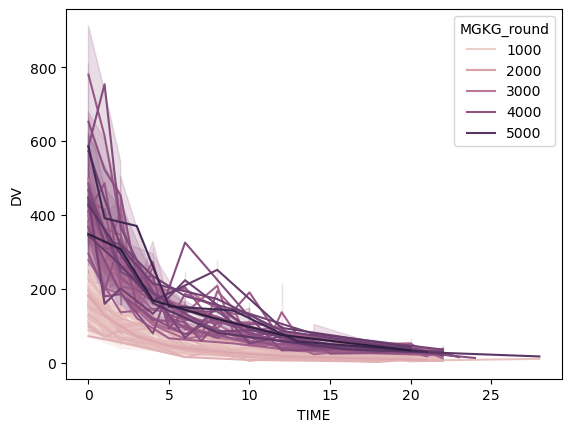

In [75]:
sns.lineplot(scale_df, x = 'TIME', y = 'DV', hue = 'MGKG_round')

In [76]:
scale_df#.loc[scale_df['DV'] > 400]

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,WT_scale,MGKG_scale,AGE_scale,MGKG_round
2,1.0,1.0,1.0,0.0,1.0,300.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3571.428571,0.327869,0.189065,0.071429,3571.0
3,1.0,1.0,1.0,1.0,2.0,300.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3571.428571,0.327869,0.189065,0.071429,3571.0
4,1.0,1.0,1.0,2.0,3.0,300.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3571.428571,0.327869,0.189065,0.071429,3571.0
5,1.0,1.0,1.0,3.0,4.0,300.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3571.428571,0.327869,0.189065,0.071429,3571.0
6,1.0,1.0,1.0,5.0,6.0,300.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3571.428571,0.327869,0.189065,0.071429,3571.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,159.0,1.0,1.0,3.0,6.0,100.0,NaN,111.0,1.0,B,1.0,33.0,95.0,1052.631579,1.049180,-0.805860,0.571429,1053.0
7,159.0,1.0,1.0,5.0,8.0,100.0,NaN,60.799999,1.0,B,1.0,33.0,95.0,1052.631579,1.049180,-0.805860,0.571429,1053.0
8,159.0,1.0,1.0,9.0,12.0,100.0,NaN,32.400002,1.0,B,1.0,33.0,95.0,1052.631579,1.049180,-0.805860,0.571429,1053.0
9,159.0,1.0,1.0,13.0,16.0,100.0,NaN,18.700001,1.0,B,1.0,33.0,95.0,1052.631579,1.049180,-0.805860,0.571429,1053.0


# Just Optimizing the ODE

In [77]:
from scipy.optimize import minimize

run_ode_only = False
if run_ode_only:
# opt_df = opt_df.loc[opt_df['TIME'] >= 1, :].copy()
    initial_guess = [0.6, 2.0]  # Initial guesses for k and Vd
    result_0 = optimize_with_checkpoint_joblib(objective_function, initial_guess, n_checkpoint=5, checkpoint_filename='check.jb', args=(
        # Bounds added to prevent negative values
        scale_df,), bounds=[(1e-6, None), (1e-6, None)])
    # result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

result_0


# With Covariates

In [78]:
from utils import ObjectiveFunctionColumn

In [79]:
from utils import arbitrary_objective_function
import warnings
import joblib as jb

run_test_mod = False
if run_test_mod:
    warnings.filterwarnings("error", category= RuntimeWarning)

    initial_guess = [np.log(0.6), np.log(2.0), 0, 0, 0 ] 
    objective_func_arbit_allometric = partial(arbitrary_objective_function,
                                dep_vars = {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                    ObjectiveFunctionColumn('SEX')],
                                            'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                            model_method='allometric', 
                                                                            allometric_norm_value=wt_scaler.transform([[70]])[0][0]
                                                                            )]})
    result_arbit_allo = optimize_with_checkpoint_joblib(objective_func_arbit_allometric, initial_guess, n_checkpoint=5, checkpoint_filename='check_args_arbit_al.jb', args=(
        # Bounds added to prevent negative values
        scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None),])

    with open('result_arbit_allo.jb', 'wb') as f:
        jb.dump(result_arbit_allo, f)
else:
    with open('result_arbit_allo.jb', 'rb') as f:
        result_arbit_allo = jb.load(f)

In [80]:
result_arbit_allo

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1815086.6522424195
        x: [-9.810e-01  2.429e-02 -2.122e-01 -5.101e-01  4.790e-01]
      nit: 4
      jac: [ 4.695e+05 -3.533e+05 -4.066e+05  3.217e+05 -7.708e+03]
     nfev: 84
     njev: 14
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [81]:
from utils import OneCompartmentModel
from diffeqs import( OneCompartmentFODiffEq,
                    mm_one_compartment_model,
                    first_order_one_compartment_model,
                    first_order_one_compartment_model2,
                    parallel_elim_one_compartment_model, 
                    one_compartment_absorption
                    )

In [82]:
diffeq_obj = OneCompartmentFODiffEq()
pk_model_function = diffeq_obj.diff_eq()

In [128]:

from utils import sum_of_squares_loss, numba_one_compartment_model, PopulationCoeffcient, ODEInitVals, mean_squared_error_loss, huber_loss
import cProfile

mods = {}
orig_sse_mod = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV')],
     population_coeff=[PopulationCoeffcient('cl', .6), PopulationCoeffcient('vd', 1)],
     dep_vars= {'cl':[ ObjectiveFunctionColumn('AGE'),
                                                ObjectiveFunctionColumn('SEX' ),
                                                ObjectiveFunctionColumn('WT',
                                                                         model_method='allometric',
                                                                         
                                                                         #allometric_norm_value=wt_scaler.transform([[70]])[0][0], 
                                                                         allometric_norm_value=70,
                                                                         )
                                                ],
                                           'vd':[ObjectiveFunctionColumn('WT',
                                                                         model_method='allometric',
                                                                         
                                                                         #allometric_norm_value=wt_scaler.transform([[70]])[0][0], 
                                                                         allometric_norm_value=70,
                                                                         )]}, 
                              loss_function=mean_squared_error_loss, 
                              optimizer_tol=None, 
                              pk_model_function=first_order_one_compartment_model2
                              )

mods['see_konly'] = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV')],
     population_coeff=[PopulationCoeffcient('k', .6/2.0), ],
     dep_vars= None, 
                              loss_function=sum_of_squares_loss, 
                              optimizer_tol=None, 
                              pk_model_function=first_order_one_compartment_model
                              )

mods['see_konly_no_init'] = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV')],
     population_coeff=None,
     dep_vars= None, 
                              loss_function=sum_of_squares_loss, 
                              optimizer_tol=None, 
                              pk_model_function=first_order_one_compartment_model, 
                              #ode_solver_method='BDF'
                              )



mods['mod_sse_mm_radau'] = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV')],
     population_coeff=[PopulationCoeffcient('vmax', 40), PopulationCoeffcient('km', 200)],
     dep_vars=None,
                              loss_function=sum_of_squares_loss, 
                              optimizer_tol=None, 
                              pk_model_function=mm_one_compartment_model, 
                              ode_solver_method='Radau'
                              )

mods['mod_sse_parallel_bdf'] = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV')],
     population_coeff=None,
     dep_vars=None,
                              loss_function=sum_of_squares_loss, 
                              optimizer_tol=None, 
                              pk_model_function=parallel_elim_one_compartment_model, 
                              #ode_solver_method='Radau'
                              )

mod_sse_mm = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV')],
     population_coeff=None,
     dep_vars=None,
                              loss_function=sum_of_squares_loss, 
                              optimizer_tol=None, 
                              pk_model_function=mm_one_compartment_model, 
                              #ode_solver_method='BDF'
                              )

mod_see_abs = OneCompartmentModel(
     ode_t0_cols=[ODEInitVals('DV'), ODEInitVals('MGKG')],
     population_coeff=None,
     dep_vars=None,
     #dep_vars={'ka':[ObjectiveFunctionColumn(column_name = 'FORM'), ObjectiveFunctionColumn('SEX')],
               #  'cl':[ObjectiveFunctionColumn('WT_scale',
               #                               model_method='allometric',
               #                               allometric_norm_value=wt_scaler.transform([[70]])[0][0],)], 
               #   'vd':[ObjectiveFunctionColumn('WT_scale',
               #                               model_method='allometric',
               #                               allometric_norm_value=wt_scaler.transform([[70]])[0][0],),                                                        
               #                                                           ]
              # },
                              loss_function=sum_of_squares_loss, 
                              optimizer_tol=None, 
                              pk_model_function=one_compartment_absorption, 
                              #ode_solver_method='BDF'
                              )

In [129]:
orig_sse_mod = orig_sse_mod.fit2(scale_df,checkpoint_filename=f'mod_abs_test.jb', parallel=False, parallel_n_jobs=4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16600D+03    |proj g|=  2.45267D+05

At iterate    1    f=  2.32331D+03    |proj g|=  2.02365D+04

At iterate    2    f=  2.31288D+03    |proj g|=  1.04151D+04

At iterate    3    f=  2.30882D+03    |proj g|=  1.91668D+03

At iterate    4    f=  2.30682D+03    |proj g|=  3.51405D+03

At iterate    5    f=  2.30004D+03    |proj g|=  9.13554D+03
Iteration 5: Checkpoint saved to logs/mod_abs_test__20__5.jb

At iterate    6    f=  2.27313D+03    |proj g|=  2.33012D+04

At iterate    7    f=  2.21812D+03    |proj g|=  4.03959D+04

At iterate    8    f=  2.09766D+03    |proj g|=  6.01251D+04

At iterate    9    f=  1.92528D+03    |proj g|=  6.42603D+04

At iterate   10    f=  1.77563D+03    |proj g|=  3.77322D+04
Iteration 10: Checkpoint saved to logs/mod_abs_test__20__10.jb

At iterate   11    f=  1.7

In [138]:
scale_df = scale_df.reset_index(drop = True)

In [139]:
from tqdm import tqdm 

n_boots = 1000
mods = []
for idx in tqdm(range(n_boots)):
    tmp_lab = scale_df['SUBJID'].drop_duplicates().sample(frac = 1, replace=True).reset_index().copy()
    tmp_lab['cumidx'] = tmp_lab.groupby('SUBJID').cumcount()
    tmp_lab['boot_sub'] = tmp_lab['SUBJID'].astype(str) + '_' + tmp_lab['cumidx'].astype(str)
    boot_df = tmp_lab.merge(scale_df.reset_index(), how = 'left', on = 'SUBJID')
    boot_df['SUBJID'] = boot_df['boot_sub']

    orig_sse_mod = orig_sse_mod.fit2(boot_df,checkpoint_filename=f'mod_abs_test.jb', parallel=False, parallel_n_jobs=4)
    mods.append(orig_sse_mod)

  0%|          | 0/1000 [00:00<?, ?it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67358D+04    |proj g|=  1.07378D+05

At iterate    1    f=  3.41252D+04    |proj g|=  5.77499D+04

At iterate    2    f=  3.38578D+04    |proj g|=  7.58155D+03

At iterate    3    f=  3.38527D+04    |proj g|=  1.72522D+03

At iterate    4    f=  3.38475D+04    |proj g|=  1.71179D+03

Iteration 5: Checkpoint saved to logs/mod_abs_test__25__5.jb
At iterate    5    f=  3.37931D+04    |proj g|=  1.54182D+04

At iterate    6    f=  3.36793D+04    |proj g|=  3.29276D+04

At iterate    7    f=  3.33907D+04    |proj g|=  5.42099D+04

At iterate    8    f=  3.28519D+04    |proj g|=  5.95774D+04

At iterate    9    f=  3.25714D+04    |proj g|=  2.91585D+04

At iterate   10    f=  3.25061D+04    |proj g|=  2.60299D+04
Iteration 10: Checkpoint saved to logs/mod_abs_test__25__10.jb

At iterate   11    f=  3.2

  0%|          | 1/1000 [01:05<18:14:02, 65.71s/it]


At iterate   41    f=  3.23500D+04    |proj g|=  7.05768D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     50      1     0     0   7.058D-02   3.235D+04
  F =   32350.033709172905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47689D+04    |proj g|=  2.66064D+04

At iterate    1    f=  4.45973D+04    |proj g|=  1.01621D+04

At iterate    2    f=  4.45561D+04    |proj g|=  3.76069D+03

At iterate    3    f=  4.45456D+04    |proj g|=  7.42026D+02

At iterate    4    f=  4.45428D+04    |proj g|=  7.26293D+02

At iterate    5    f=  4.45390D+04    |proj g|=  1.77534D+03
Iteration 5: Checkpoint saved to logs/mod_abs_test__40__5.jb

At iterate    6    f=  4.45227D+04    |proj g|=  5.48473D+03

At iterate    7    f=  4.44899D+04    |proj g|=  1.04753D+04

At iterate    8    f=  4.43624D+04    |proj g|=  2.34410D+04

At iterate    9    f=  4.41076D+04    |proj g|=  3.73595D+04

At iterate   10    f=  4.38108D+04    |proj g|=  2.32692D+04
Iteration 10: Checkpoint saved to logs/mod_abs_test__40__10.jb

At iterate   11    f=  4.3

  0%|          | 1/1000 [03:08<52:17:11, 188.42s/it]


KeyboardInterrupt: 

In [130]:
tmp_df = scale_df.copy()
tmp_df['pred_conc'] = orig_sse_mod.predict2(scale_df)

In [131]:
tmp_df['sq_error'] = (tmp_df['DV'] - tmp_df['pred_conc'])**2
a = tmp_df.groupby('SUBJID')['sq_error'].mean().reset_index().rename(columns = {'sq_error':'mse'})
mplot = tmp_df.merge(a, how = 'left', on = 'SUBJID')[['mse', 'FORM', 'TRTCD', 'WT', 'MGKG', 'AGE']].drop_duplicates()

In [132]:
tmp_df['resid'] =  tmp_df['pred_conc'] - tmp_df['DV']
tmp_df['%resid'] = (tmp_df['pred_conc'] - tmp_df['DV']) / ((tmp_df['pred_conc'] + tmp_df['DV'])/2)

<Axes: xlabel='TIME', ylabel='resid'>

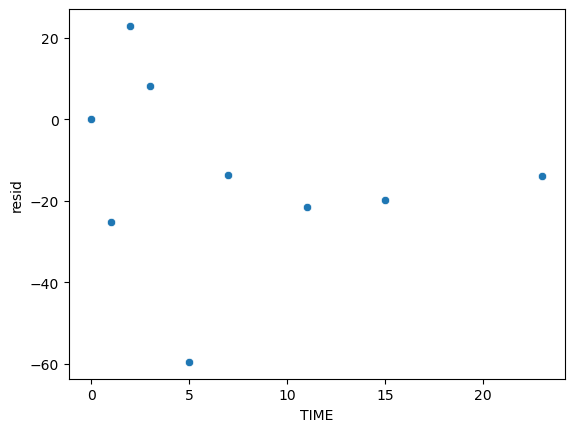

In [133]:
sns.scatterplot(tmp_df.loc[tmp_df['SUBJID'] == 1, :], x = 'TIME', y = 'resid')

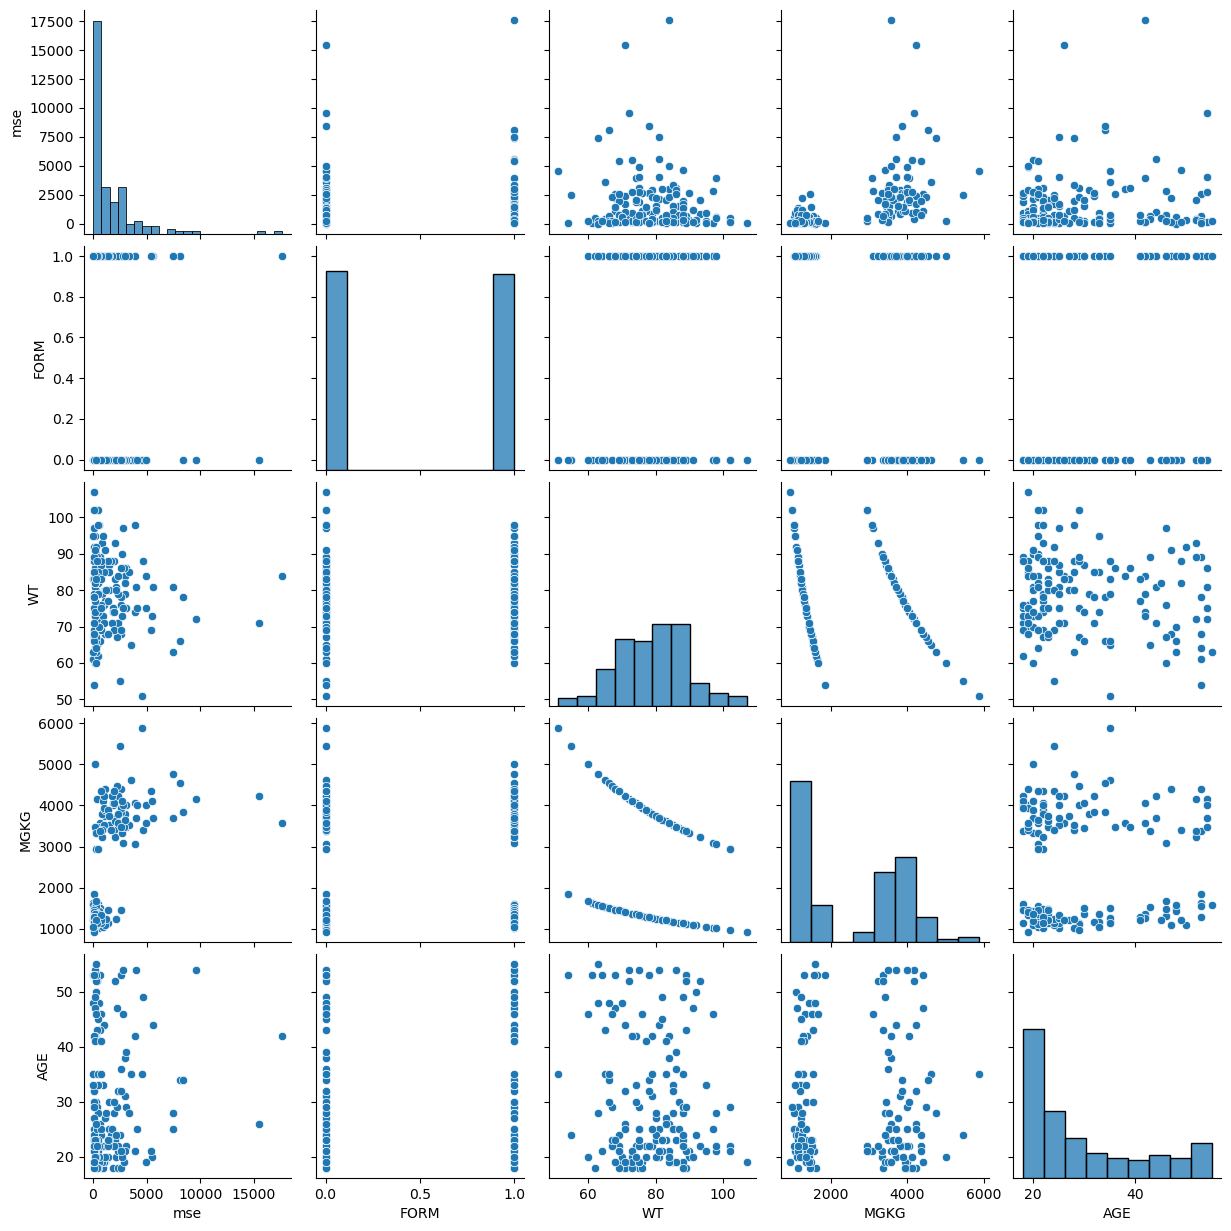

In [134]:
sns.pairplot(mplot)

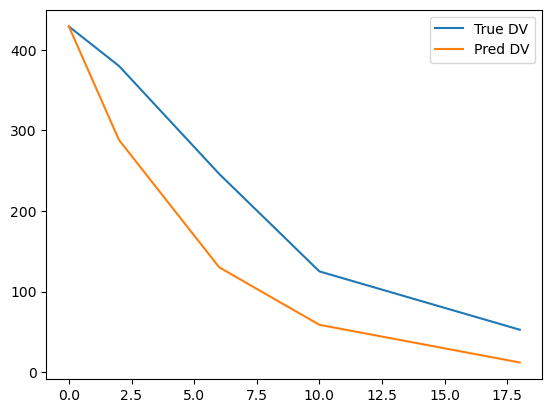

In [137]:
sub = 10
plot_me = tmp_df.loc[tmp_df['SUBJID'] == sub, :]
plt.plot(plot_me['TIME'], plot_me['DV'], label = 'True DV')
plt.plot(plot_me['TIME'], plot_me['pred_conc'], label = 'Pred DV')
plt.legend()

In [25]:
_.y

array([  0.        ,  35.29999924, 275.        , ...,   1.70000005,
         1.41999996,   0.85100001])

In [19]:
_ = orig_sse_mod.fit2(scale_df,checkpoint_filename=f'mod_allo_test.jb', parallel=False, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15942D+06    |proj g|=  7.62488D+06


 This problem is unconstrained.



At iterate    1    f=  2.21855D+06    |proj g|=  3.01774D+06

At iterate    2    f=  1.99650D+06    |proj g|=  2.51184D+06

At iterate    3    f=  1.74668D+06    |proj g|=  3.09021D+05

At iterate    4    f=  1.73980D+06    |proj g|=  2.97677D+05

At iterate    5    f=  1.73452D+06    |proj g|=  1.87682D+05
Iteration 5: Checkpoint saved to logs/mod_allo_test__15__5.jb

At iterate    6    f=  1.73291D+06    |proj g|=  3.35968D+04

At iterate    7    f=  1.73285D+06    |proj g|=  1.47412D+04

At iterate    8    f=  1.73284D+06    |proj g|=  5.31171D+03

At iterate    9    f=  1.73284D+06    |proj g|=  4.78486D+03

At iterate   10    f=  1.73283D+06    |proj g|=  6.19181D+03
Iteration 10: Checkpoint saved to logs/mod_allo_test__15__10.jb

At iterate   11    f=  1.73282D+06    |proj g|=  6.57211D+03

At iterate   12    f=  1.73282D+06    |proj g|=  1.53407D+03

At iterate   13    f=  1.73282D+06    |proj g|=  7.57398D+01

At iterate   14    f=  1.73282D+06    |proj g|=  7.07805D+00

     

In [20]:
np.exp(_.fit_result_['x'])

array([0.4287569 , 1.39939321, 0.91662759, 0.73975228, 0.96799804,
       1.03305876])

In [25]:
np.exp(_.fit_result_['x'])

array([0.42875754, 1.39939336, 0.91662751, 0.73975127, 1.06721238])

In [19]:
_ = mods['see_konly'].fit2(scale_df,checkpoint_filename=f'mod_see_konly_test.jb', parallel=True, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24543D+06    |proj g|=  2.89945D+06


 This problem is unconstrained.



At iterate    1    f=  1.85852D+06    |proj g|=  2.23860D+05

At iterate    2    f=  1.85649D+06    |proj g|=  2.28781D+04

At iterate    3    f=  1.85647D+06    |proj g|=  1.46055D+02

At iterate    4    f=  1.85647D+06    |proj g|=  4.65661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   4.657D-02   1.856D+06
  F =   1856467.4158051827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [20]:
_.init_vals_pd

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value,subject_level_intercept
0,k,None,True,-1.203973,False,None,False


In [21]:
_ = mods['see_konly'].fit2(scale_df,checkpoint_filename=f'mod_see_konly_test.jb', parallel=False, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24543D+06    |proj g|=  2.89945D+06


 This problem is unconstrained.



At iterate    1    f=  1.85852D+06    |proj g|=  2.23860D+05

At iterate    2    f=  1.85649D+06    |proj g|=  2.28781D+04

At iterate    3    f=  1.85647D+06    |proj g|=  1.46055D+02

At iterate    4    f=  1.85647D+06    |proj g|=  4.65661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   4.657D-02   1.856D+06
  F =   1856467.4158051827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [21]:
np.exp(_.fit_result_['x'])

array([0.23143493])

In [26]:
_.y

array([275.        , 244.        , 151.        , ...,   1.70000005,
         1.41999996,   0.85100001])

In [23]:
_.predict2(scale_df)

array([2.75000000e+02, 2.18179397e+02, 1.73074712e+02, ...,
       6.19005125e-03, 2.38746008e-05, 9.26416715e-08])

In [31]:
_.fit_result_['x']

array([18.14322407, 19.60637571])

In [17]:
mods_out = {}
for m_key in mods:
    mods_out[m_key] = mods[m_key].fit2(scale_df,checkpoint_filename=f'{m_key}_test.jb', parallel=True, parallel_n_jobs=4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24543D+06    |proj g|=  2.89945D+06

At iterate    1    f=  1.85852D+06    |proj g|=  2.23860D+05

At iterate    2    f=  1.85649D+06    |proj g|=  2.28781D+04

At iterate    3    f=  1.85647D+06    |proj g|=  1.46055D+02

At iterate    4    f=  1.85647D+06    |proj g|=  4.65661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   4.657D-02   1.856D+06
  F =   1856467.4158051827     

CONVERG

 This problem is unconstrained.



At iterate    1    f=  1.94154D+06    |proj g|=  1.40607D+06

At iterate    2    f=  1.91040D+06    |proj g|=  1.17545D+06

At iterate    3    f=  1.85656D+06    |proj g|=  4.69666D+04

At iterate    4    f=  1.85647D+06    |proj g|=  1.42669D+03

At iterate    5    f=  1.85647D+06    |proj g|=  2.02563D+00
Iteration 5: Checkpoint saved to logs/see_konly_no_init_test__5.jb

At iterate    6    f=  1.85647D+06    |proj g|=  1.39698D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6      7      1     0     0   1.397D-01   1.856D+06
  F =   1856467.4158051834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSM

 This problem is unconstrained.



At iterate    1    f=  3.90891D+07    |proj g|=  7.92715D+06

At iterate    2    f=  3.90390D+07    |proj g|=  7.22444D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/workspaces/miniconda/PK-Analysis/utils.py:482: RuntimeWarning: overflow encountered in exp
  out = np.exp((X @ theta) + pop_coeff) + 1e-6
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:125: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:125: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:125: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:125: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/scipy/integr

ValueError: array must not contain infs or NaNs

In [17]:
_ = mods['see_konly_no_init'].fit2(scale_df,checkpoint_filename='test.jb', parallel=False, parallel_n_jobs=4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99515D+06    |proj g|=  7.54893D+06

At iterate    1    f=  1.88621D+06    |proj g|=  8.68522D+05

At iterate    2    f=  1.86359D+06    |proj g|=  4.15169D+05

At iterate    3    f=  1.85647D+06    |proj g|=  9.70264D+03

At iterate    4    f=  1.85647D+06    |proj g|=  1.15833D+02

At iterate    5    f=  1.85647D+06    |proj g|=  6.98492D-02
Iteration 5: Checkpoint saved to logs/test__10__5.jb

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pro

In [21]:
_.predict2(scale_df)

array([2.75000000e+02, 2.18183024e+02, 1.73080090e+02, ...,
       6.23886211e-03, 2.43961846e-05, 2.17297103e-07])

In [17]:
mod_sse_parallel_bdf = mod_sse_parallel_bdf.fit2(scale_df,checkpoint_filename='mm_parallel_no_init.jb', parallel=False, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20196D+08    |proj g|=  1.75508D+07


 This problem is unconstrained.



At iterate    1    f=  6.44453D+06    |proj g|=  3.05588D+06

At iterate    2    f=  5.88748D+06    |proj g|=  3.73724D+05

At iterate    3    f=  5.88258D+06    |proj g|=  6.42483D+04

At iterate    4    f=  5.88252D+06    |proj g|=  4.02607D+04

At iterate    5    f=  5.88248D+06    |proj g|=  1.31544D+04
Iteration 5: Checkpoint saved to logs/mm_parallel_no_init__5.jb

At iterate    6    f=  5.88247D+06    |proj g|=  1.66518D+04

At iterate    7    f=  5.88242D+06    |proj g|=  5.14099D+04

At iterate    8    f=  5.88240D+06    |proj g|=  4.95869D+04

At iterate    9    f=  5.88223D+06    |proj g|=  5.01802D+04

At iterate   10    f=  5.88024D+06    |proj g|=  1.29537D+05
Iteration 10: Checkpoint saved to logs/mm_parallel_no_init__10.jb

At iterate   11    f=  4.03102D+06    |proj g|=  3.65517D+06

At iterate   12    f=  4.00578D+06    |proj g|=  2.91207D+06

At iterate   13    f=  3.43149D+06    |proj g|=  2.28673D+06

At iterate   14    f=  2.66950D+06    |proj g|=  2.43747D+06

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [21]:
mod_sse_parallel_bdf.init_vals_pd

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value,subject_level_intercept
0,vmax,None,True,-0.216584,False,None,False
1,km,None,True,-0.457831,False,None,False


In [19]:
mod_sse_parallel_bdf.fit_result_['x']

array([20.1323044 , 21.59520848])

In [24]:
from copy import deepcopy
mod_sse_mm_bdf_2 = deepcopy(mod_sse_mm_bdf)
mod_sse_mm_bdf_2.init_vals_pd = mod_sse_parallel_bdf.init_vals_pd.copy()

In [26]:
_.fit_result_['x']

array([20.1323044 , 21.59520848])

In [25]:
_ = mod_sse_mm_bdf_2.fit2(scale_df,checkpoint_filename='mm_no_init_cp.jb', parallel=False, parallel_n_jobs=4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20196D+08    |proj g|=  1.75508D+07

At iterate    1    f=  6.44453D+06    |proj g|=  3.05588D+06

At iterate    2    f=  5.88748D+06    |proj g|=  3.73724D+05

At iterate    3    f=  5.88258D+06    |proj g|=  6.42483D+04

At iterate    4    f=  5.88252D+06    |proj g|=  4.02607D+04

At iterate    5    f=  5.88248D+06    |proj g|=  1.31544D+04
Iteration 5: Checkpoint saved to logs/mm_no_init_cp__5.jb

At iterate    6    f=  5.88247D+06    |proj g|=  1.66518D+04

At iterate    7    f=  5.88242D+06    |proj g|=  5.14099D+04

At iterate    8    f=  5.88240D+06    |proj g|=  4.95869D+04

At iterate    9    f=  5.88223D+06    |proj g|=  5.01802D+04

At iterate   10    f=  5.88024D+06    |proj g|=  1.29537D+05
Iteration 10: Checkpoint saved to logs/mm_no_init_cp__10.jb

At iterate   11    f=  4.03102D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [22]:
mod_sse_mm_bdf = mod_sse_mm_bdf.fit2(scale_df,checkpoint_filename='mm_no_init.jb', parallel=False, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33521D+08    |proj g|=  5.77537D+06


 This problem is unconstrained.



At iterate    1    f=  1.68283D+07    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      4      1     0     0   0.000D+00   1.683D+07
  F =   16828304.754900448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [20]:
mod_sse_mm_bdf.predict2(scale_df)

array([ 2.75000000e+02,  3.20310476e-15, -1.99820878e-18, ...,
        6.70143438e-23,  5.35477186e-24,  1.83897258e-28])

In [21]:
mod_sse_mm = mod_sse_mm.fit2(scale_df,checkpoint_filename='mm_no_init.jb', parallel=False, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29037D+08    |proj g|=  9.94530D+06


 This problem is unconstrained.



At iterate    1    f=  6.98363D+07    |proj g|=  1.80059D+07

At iterate    2    f=  6.98358D+07    |proj g|=  1.96421D+07
  ys=-4.243E+01  -gs= 4.709E+02 BFGS update SKIPPED

At iterate    3    f=  6.97642D+07    |proj g|=  5.34741D+09

At iterate    4    f=  6.97634D+07    |proj g|=  3.64440D+08

Iteration 5: Checkpoint saved to logs/mm_no_init__5.jb
At iterate    5    f=  6.97630D+07    |proj g|=  1.86601D+08

At iterate    6    f=  6.97630D+07    |proj g|=  1.48536D+08

At iterate    7    f=  6.97630D+07    |proj g|=  8.83842D+07

At iterate    8    f=  6.97630D+07    |proj g|=  1.18172D+09


KeyboardInterrupt: 

In [22]:

for m in mods:
    mods[m] = mods[m]

In [34]:
np.exp(mods['see_no_cov'].fit_result_['x'])

array([0.52699407, 2.27706578])

In [35]:
np.exp(mods['see_no_cov_no_pop'].fit_result_['x'])

array([0.08435448, 0.3644864 ])

In [36]:
np.exp(mods['orig_sse'].fit_result_['x'])

array([0.44227816, 1.35661307, 0.89983087, 0.70093366, 0.98110022])

In [19]:
mod_sse_mm = mod_sse_mm.fit2(scale_df,checkpoint_filename='check_test2_mm.jb', parallel=True, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27099D+08    |proj g|=  1.16872D+07


 This problem is unconstrained.



At iterate    1    f=  7.43586D+07    |proj g|=  8.38972D+08

At iterate    2    f=  7.43181D+07    |proj g|=  1.24523D+08

At iterate    3    f=  7.43177D+07    |proj g|=  3.08267D+07

At iterate    4    f=  7.42191D+07    |proj g|=  3.38791D+07
  ys=-2.062E+02  -gs= 2.434E+03 BFGS update SKIPPED

At iterate    5    f=  7.41049D+07    |proj g|=  5.58327D+07
Iteration 5: Checkpoint saved to logs/check_test2_mm__5__5.jb
  ys=-1.965E+03  -gs= 3.084E+03 BFGS update SKIPPED


KeyboardInterrupt: 

In [17]:
mod_sse = mod_sse.fit2(scale_df, checkpoint_filename='check_test2.jb', parallel=True, parallel_n_jobs=4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47340D+06    |proj g|=  7.75525D+06

At iterate    1    f=  2.22428D+06    |proj g|=  3.11198D+06

At iterate    2    f=  2.04938D+06    |proj g|=  2.73193D+06

At iterate    3    f=  1.76539D+06    |proj g|=  3.57271D+05

At iterate    4    f=  1.75967D+06    |proj g|=  2.67493D+05

At iterate    5    f=  1.75547D+06    |proj g|=  1.85133D+05
Iteration 5: Checkpoint saved to logs/check_test2__5__5.jb

At iterate    6    f=  1.75356D+06    |proj g|=  5.54949D+04

At iterate    7    f=  1.75331D+06    |proj g|=  2.18176D+04

At iterate    8    f=  1.75316D+06    |proj g|=  3.42912D+04

At iterate    9    f=  1.75299D+06    |proj g|=  3.72207D+04

At iterate   10    f=  1.75279D+06    |proj g|=  2.22034D+04
Iteration 10: Checkpoint saved to logs/check_test2__5__10.jb

At iterate   11    f=  1.75272

In [21]:
np.exp(mod_sse.fit_result_['x'])

array([0.36111812, 1.10767102, 0.89983385, 0.70093422, 0.981095  ])

In [23]:
mod_sse_no_cov = mod_sse_no_cov.fit2(scale_df, checkpoint_filename='check_test2_nocov.jb', parallel=True, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24542D+06    |proj g|=  2.89943D+06


 This problem is unconstrained.



At iterate    1    f=  1.86205D+06    |proj g|=  3.68038D+05

At iterate    2    f=  1.85653D+06    |proj g|=  3.80382D+04

At iterate    3    f=  1.85647D+06    |proj g|=  3.98513D+02

At iterate    4    f=  1.85647D+06    |proj g|=  3.72529D-01

At iterate    5    f=  1.85647D+06    |proj g|=  1.86265D-01
Iteration 5: Checkpoint saved to logs/check_test2_nocov__5.jb

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   1.863D-01   1.856D+06
  F =   1856467.4158051831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [18]:
mod_sse_no_cov = mod_sse_no_cov.fit2(scale_df, checkpoint_filename='check_test2_nocov.jb', parallel=True, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24542D+06    |proj g|=  2.89943D+06


 This problem is unconstrained.



At iterate    1    f=  1.86205D+06    |proj g|=  3.68038D+05

At iterate    2    f=  1.85653D+06    |proj g|=  3.80382D+04

At iterate    3    f=  1.85647D+06    |proj g|=  3.98513D+02

At iterate    4    f=  1.85647D+06    |proj g|=  3.72529D-01

At iterate    5    f=  1.85647D+06    |proj g|=  1.86265D-01
Iteration 5: Checkpoint saved to logs/check_test2_nocov__5.jb

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   1.863D-01   1.856D+06
  F =   1856467.4158051831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [17]:
mod_sse.predict2(scale_df)

array([2.75000000e+02, 2.18899784e+02, 1.74220057e+02, ...,
       1.07801534e-02, 5.59765801e-05, 3.30577211e-07])

In [19]:
np.exp(mod_sse.fit_result_['x'])

array([0.6254745 , 1.91854309, 0.89983208, 0.70093536, 0.98109918])

In [17]:
#with numba
mod_sse = mod_sse.fit2(scale_df, checkpoint_filename='check_test2.jb', parallel=True, parallel_n_jobs=2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24542D+06    |proj g|=  2.89943D+06


 This problem is unconstrained.



At iterate    1    f=  1.81944D+06    |proj g|=  7.18267D+05

At iterate    2    f=  1.80455D+06    |proj g|=  2.25158D+05

At iterate    3    f=  1.78737D+06    |proj g|=  2.75996D+05

At iterate    4    f=  1.76216D+06    |proj g|=  1.56072D+05

At iterate    5    f=  1.75378D+06    |proj g|=  1.05386D+05
Iteration 5: Checkpoint saved to logs/check_test2__5.jb

At iterate    6    f=  1.75291D+06    |proj g|=  5.70806D+04

At iterate    7    f=  1.75272D+06    |proj g|=  1.64185D+03

At iterate    8    f=  1.75272D+06    |proj g|=  3.64380D+01

At iterate    9    f=  1.75272D+06    |proj g|=  6.21658D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tni

In [ ]:
mod_sse = mod_sse.fit2(scale_df, checkpoint_filename='check_test2.jb', parallel=True, parallel_n_jobs=4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24542D+06    |proj g|=  2.89943D+06


 This problem is unconstrained.



At iterate    1    f=  1.81944D+06    |proj g|=  7.18267D+05

At iterate    2    f=  1.80455D+06    |proj g|=  2.25158D+05

At iterate    3    f=  1.78737D+06    |proj g|=  2.75996D+05

At iterate    4    f=  1.76216D+06    |proj g|=  1.56072D+05

At iterate    5    f=  1.75378D+06    |proj g|=  1.05386D+05
Iteration 5: Checkpoint saved to logs/check_test2__5.jb

At iterate    6    f=  1.75291D+06    |proj g|=  5.70806D+04

At iterate    7    f=  1.75272D+06    |proj g|=  1.64185D+03

At iterate    8    f=  1.75272D+06    |proj g|=  3.64380D+01

At iterate    9    f=  1.75272D+06    |proj g|=  6.21658D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tni

In [17]:
mod_sse2= mod_sse2.fit(scale_df)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24542D+06    |proj g|=  2.89943D+06


 This problem is unconstrained.



At iterate    1    f=  1.81944D+06    |proj g|=  7.18267D+05

At iterate    2    f=  1.80455D+06    |proj g|=  2.25158D+05

At iterate    3    f=  1.78737D+06    |proj g|=  2.75996D+05

At iterate    4    f=  1.76216D+06    |proj g|=  1.56072D+05

At iterate    5    f=  1.75378D+06    |proj g|=  1.05386D+05
Iteration 5: Checkpoint saved to logs/check_test__5.jb

At iterate    6    f=  1.75291D+06    |proj g|=  5.70817D+04

At iterate    7    f=  1.75272D+06    |proj g|=  1.64236D+03

At iterate    8    f=  1.75272D+06    |proj g|=  3.61353D+01

At iterate    9    f=  1.75272D+06    |proj g|=  6.07688D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnin

In [17]:
mod_sse2.objective_calls

78

In [17]:
import cProfile
import pstats

#profiler = cProfile.Profile()
#profiler.enable()

mod_sse = mod_sse.fit(scale_df, parallel=True, warm_start=False, checkpoint_filename='check_allo_sse.jb')

#profiler.disable()
#stats = pstats.Stats(profiler).sort_stats('cumtime') # 'cumtime' for total time in a function


Iteration 5: Checkpoint saved to logs/check_allo_sse__5.jb


In [22]:
sse_df = mod_sse.predict(scale_df, return_df=True)

In [18]:
mod_sse.fit_result_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1752721.7046898128
        x: [-4.692e-01  6.516e-01 -1.055e-01 -3.553e-01 -1.908e-02]
      nit: 9
      jac: [-5.355e-01  6.054e-01 -6.985e-02  3.073e+00 -6.077e+00]
     nfev: 78
     njev: 13
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [19]:
mod_sse.fit_result_summary_

,population_coeff,model_coeff,model_coeff_indep_var,log_coeff,log_coeff_history_final,coeff_estimates_equal,coeff
0,True,k,None,-0.469245,-0.469245,True,0.625474
1,True,vd,None,0.651566,0.651566,True,1.918543
2,False,k,AGE_scale,-0.105547,-0.105547,True,0.899832
3,False,k,SEX,-0.355340,-0.355340,True,0.700935
4,False,vd,WT_scale,-0.019082,-0.019082,False,0.981099


In [20]:
from utils import OneCompartmentModel, mean_squared_error_loss


mod_mse = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='linear', 
                                                                         #allometric_norm_value=wt_scaler.transform([[70]])[0][0]
                                                                         )]}, 
                          loss_function=mean_squared_error_loss
                          )
mod_mse = mod_mse.fit(scale_df, parallel=True, checkpoint_filename='check_allo_mse.jb')

Iteration 5: Checkpoint saved to logs/check_allo_mse__15__5.jb


In [21]:
mod_mse.fit_result_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1081.9269782036092
        x: [-4.692e-01  6.516e-01 -1.055e-01 -3.553e-01 -1.908e-02]
      nit: 9
      jac: [-2.046e-04  3.638e-04 -6.821e-05  1.887e-03 -3.820e-03]
     nfev: 78
     njev: 13
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [23]:
rse_df = mod_mse.predict(scale_df, return_df=True)

In [20]:
from utils import huber_loss

mod_huber = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='linear', 
                                                                         
                                                                         )]}, 
                          loss_function=huber_loss,
                          loss_params={'delta':1.73}, 
                          optimizer_tol=1e-5
                          )
mod_huber = mod_huber.fit2(scale_df, parallel=True, parallel_n_jobs=4, checkpoint_filename='huber_log.jb')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54922D+01    |proj g|=  2.51729D+01


 This problem is unconstrained.



At iterate    1    f=  3.05319D+01    |proj g|=  1.03816D+01

At iterate    2    f=  3.00048D+01    |proj g|=  5.00334D+00

At iterate    3    f=  2.98923D+01    |proj g|=  1.74563D+00

At iterate    4    f=  2.98186D+01    |proj g|=  8.75281D-01

Iteration 5: Checkpoint saved to logs/huber_log__5.jb
At iterate    5    f=  2.97633D+01    |proj g|=  1.38042D+00

At iterate    6    f=  2.96746D+01    |proj g|=  3.41867D+00

At iterate    7    f=  2.95968D+01    |proj g|=  1.36899D+00

At iterate    8    f=  2.95796D+01    |proj g|=  7.75420D-01

At iterate    9    f=  2.95773D+01    |proj g|=  3.23592D-01

At iterate   10    f=  2.95763D+01    |proj g|=  1.60589D-01
Iteration 10: Checkpoint saved to logs/huber_log__10.jb

At iterate   11    f=  2.95761D+01    |proj g|=  5.65404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact 

In [22]:
np.exp(mod_huber.fit_result_['x'])

array([0.59805546, 2.00650275, 0.91321679, 0.67233459, 0.92652849])

In [27]:
mod_huber.fit_result_summary_

,population_coeff,model_coeff,model_coeff_indep_var,log_coeff,log_coeff_history_final,coeff_estimates_equal,coeff
0,True,k,None,-0.514065,-0.514065,True,0.598060
1,True,vd,None,0.696386,0.696386,True,2.006488
2,False,k,AGE_scale,-0.090781,-0.090781,True,0.913217
3,False,k,SEX,-0.397012,-0.397012,True,0.672326
4,False,vd,WT_scale,-0.076311,-0.076311,False,0.926528


In [28]:
huber_df = mod_huber.predict(scale_df, return_df=True)

In [25]:
from sklearn.model_selection import GroupKFold
from utils import OneCompartmentModel
huber_deltas = np.linspace(1.25,1.9, 30)
#best_delta = 1.7655
best_delta = 1.723
tols = np.linspace(1e-2,1e-10, 100 )
cv_df = scale_df.copy().reset_index(drop = True)
X = cv_df.drop(columns = 'DV').copy()
y = cv_df['DV'].copy()
groups = cv_df['SUBJID'].copy()
allo_scaler = wt_scaler.transform([[70]])[0][0]


/opt/conda/envs/pySunODE/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [26]:

import warnings
from tqdm import tqdm
from utils import huber_loss
import joblib as jb

g_kfold = GroupKFold(n_splits=10, shuffle = True, random_state=42)
g_kfold.get_n_splits(X, y, groups)
fit_parallel = True






res = []
for idx, d in enumerate(tqdm(tols)):
    cv_error = []
    train_idx_history = []
    test_idx_history = [] 
    for i, (train_index, test_index) in enumerate(g_kfold.split(X, y, groups)):
        
        train_X = cv_df.iloc[train_index, :].copy()
        test_X = cv_df.iloc[test_index, :].copy()  

        mod_huber = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale', ),
                                                    ObjectiveFunctionColumn('SEX') ],
                                            'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                            model_method='linear', 
                                                                            
                                                                            
                                                                            )]}, 
                            loss_function=huber_loss,
                            loss_params={'delta':best_delta}, 
                            optimizer_tol=d
                            )
        mod_huber = mod_huber.fit(train_X, parallel=fit_parallel,parallel_n_jobs=4 ,checkpoint_filename=f'huber_opt_d{d}_cv{i}.jb')
        test_preds = mod_huber.predict(test_X, parallel=fit_parallel,parallel_n_jobs=4 )
        inner_mad = np.mean(np.abs(test_preds - test_X['DV'].values))
        cv_error.append(inner_mad)

        train_idx_history.append(train_index)
        test_idx_history.append(test_index)
    res.append(
        {
            'd':d, 
            'train_idx':train_idx_history, 
            'test_idx':test_idx_history,
            'cv_error':cv_error,
            'avg_cv_error':np.mean(cv_error) if all((i is not None for i in cv_error)) else None
        }
    )
    
    res_df = pd.DataFrame(res)
    with open('cv_log_tol.jb', 'wb') as f:
        jb.dump(res_df, f)
res_df = pd.DataFrame(res)
        

 33%|███▎      | 33/100 [49:33<1:40:36, 90.09s/it]


KeyboardInterrupt: 

In [16]:
import joblib as jb
debug_X = cv_df.iloc[debug_idx, :].copy()
debug_X_test = cv_df.iloc[debug_test_idx, :].copy()

with open('debug_X.jb', 'wb') as f:
    jb.dump(debug_X, f)
with open('debug_X_test.jb', 'wb') as f:
    jb.dump(debug_X_test, f)

In [21]:
import joblib as jb
from utils import OneCompartmentModel, huber_loss

with open('debug_X.jb', 'rb') as f:
    debug_X = jb.load(f)

In [17]:
mod_huber = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                            ObjectiveFunctionColumn('SEX')],
                                    'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                    model_method='linear', 
                                                                    #allometric_norm_value=allo_scaler
                                                                    )]}, 
                    loss_function=huber_loss,
                    loss_params={'delta':best_delta}, 
                    optimizer_tol=1e-3
                    )
mod_huber = mod_huber.fit(scale_df, parallel=True,parallel_n_jobs=4 ,checkpoint_filename=f'huber_opt_debug.jb')

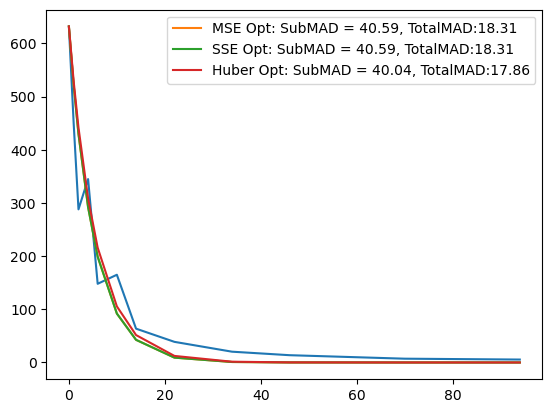

In [29]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1)
plot_df = rse_df.loc[rse_df['SUBJID'] == 5, :]
global_mad = np.mean(np.abs(rse_df['DV'] - rse_df['pred_y']))
mad = np.mean(np.abs(plot_df['DV'] - plot_df['pred_y']))
axs.plot(plot_df['TIME'], plot_df['DV'])
axs.plot(plot_df['TIME'], plot_df['pred_y'], label = f'MSE Opt: SubMAD = {np.round(mad, 2)}, TotalMAD:{np.round(global_mad, 2)}' )

plot_df = sse_df.loc[sse_df['SUBJID'] == 5, :]
global_mad = np.mean(np.abs(sse_df['DV'] - sse_df['pred_y']))
mad = np.mean(np.abs(plot_df['DV'] - plot_df['pred_y']))
#axs[0].plot(plot_df['TIME'], plot_df['DV'])
axs.plot(plot_df['TIME'], plot_df['pred_y'], label = f'SSE Opt: SubMAD = {np.round(mad, 2)}, TotalMAD:{np.round(global_mad, 2)}')

plot_df = huber_df.loc[huber_df['SUBJID'] == 5, :]
global_mad = np.mean(np.abs(huber_df['DV'] - huber_df['pred_y']))
mad = np.mean(np.abs(plot_df['DV'] - plot_df['pred_y']))
#axs[0].plot(plot_df['TIME'], plot_df['DV'])
axs.plot(plot_df['TIME'], plot_df['pred_y'], label = f'Huber Opt: SubMAD = {np.round(mad, 2)}, TotalMAD:{np.round(global_mad, 2)}')
plt.legend()

In [ ]:
from sklearn.

In [19]:
mod_lin_mse = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',)]})
mod_lin_mse = mod_lin_mse.fit(scale_df)

No checkpoint found, starting from initial guess.
1
no log
2
no log
3
no log
4
no log
5
Iteration 5: Checkpoint saved to check_test_5.jb
no log


In [20]:
mod_lin_mse.fit_result_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1117.8093170102954
        x: [-5.936e-01  8.015e-01 -4.243e-02 -8.184e-02  1.066e-02]
      nit: 5
      jac: [ 4.338e+02  6.055e+02  5.694e+02  4.067e+02 -1.042e+01]
     nfev: 228
     njev: 38
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [21]:
mod_lin_sse = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',)]},
                                  loss_function=sum_of_squares_loss
                                  )
mod_lin_sse = mod_lin_sse.fit(scale_df)

No checkpoint found, starting from initial guess.


1
no log
2
no log
3
no log
4
no log
5
Iteration 5: Checkpoint saved to check_test_5.jb
no log
6
no log
7
no log
8
no log
9
no log
10
Iteration 10: Checkpoint saved to check_test_10.jb
no log
11
no log
12
no log
13
no log
14
no log
15
Iteration 15: Checkpoint saved to check_test_15.jb
no log


KeyboardInterrupt: 

In [17]:
mod_lin_sse.fit_result_

<function utils.one_compartment_model(t, y, k, Vd, dose)>

No checkpoint found, starting from initial guess.


1
no log
2
no log
3
no log
4
no log


In [19]:
mod.fit_result_summary_

,population_coeff,model_coeff,model_coeff_indep_var,log_coeff,log_coeff_history_final,coeff_estimates_equal,coeff
0,True,k,None,-0.981034,-0.981034,True,0.374923
1,True,vd,None,0.024289,0.024289,True,1.024586
2,False,k,AGE_scale,-0.212214,-0.212214,True,0.808791
3,False,k,SEX,-0.510118,-0.510118,True,0.600425
4,False,vd,WT_scale,0.478995,0.478995,False,1.614451


In [22]:
mod.betas

{'k': {'AGE_scale': ObjectiveFunctionBeta(column_name='AGE_scale', value=-0.21221418486812021, allometric_norm_value=None, model_method='linear', optimization_lower_bound=None, optimization_upper_bound=None),
  'SEX': ObjectiveFunctionBeta(column_name='SEX', value=-0.5101181836714316, allometric_norm_value=None, model_method='linear', optimization_lower_bound=None, optimization_upper_bound=None)},
 'vd': {'WT_scale': ObjectiveFunctionBeta(column_name='WT_scale', value=0.4789950131266872, allometric_norm_value=-0.5625, model_method='allometric', optimization_lower_bound=None, optimization_upper_bound=None)}}

In [27]:
mod.predict(scale_df)

[275.0,
 219.41004075629095,
 175.03386587702224,
 139.58268793813124,
 88.9423037340149,
 56.6078393802286,
 22.949008650562817,
 9.303864360478595,
 1.529228586544097,
 0.10190992181331796,
 0.006791884038671114,
 3.0273384810627132e-05,
 2.125513197246342e-07,
 625.0,
 481.17573769511966,
 370.37613649441204,
 219.53490305344727,
 130.1742981976813,
 45.74840597829629,
 16.084801005138267,
 1.9884628315634594,
 0.08631915573715676,
 0.0037505437025481115,
 7.204241033197959e-06,
 6.52943082436209e-08,
 498.0,
 405.4704513439597,
 330.0988876867474,
 218.70932158208004,
 145.17709307579506,
 63.82682873673082,
 28.058975448400865,
 5.422084397487072,
 0.4606572228708948,
 0.03915411389023722,
 0.00028300209234933366,
 2.0976521634348977e-06,
 302.0,
 236.96364925607656,
 185.9030282198404,
 114.43104717234311,
 70.50760415245051,
 26.73406925117478,
 10.137453888528018,
 1.458171696650773,
 0.07959696157113466,
 0.004340410232303384,
 1.3029799550901507e-05,
 6.707379605981528e-08,
 

In [ ]:

objective_func_arbit_linear = partial(arbitrary_objective_function,
                               dep_vars = {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',)]}
                               )


result_arbit_lin = optimize_with_checkpoint_joblib(objective_func_arbit_linear, initial_guess, n_checkpoint=5, checkpoint_filename='check_args_arbit_lin.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None),])
                             

In [18]:
np.exp(result_arbit_allo['x'])

array([0.37492311, 1.02458642, 0.80879145, 0.60042461, 1.61445107])

In [19]:
np.exp(result_arbit_lin['x'])

array([0.58163838, 2.20294476, 0.94509567, 0.86590837, 1.03079841])

In [12]:
np.exp(result_arbit['x'])

array([0.37492311, 1.02458642, 0.80879145, 0.60042461, 1.61445107])

In [14]:
np.exp(result_arbit['x'])

array([0.58163838, 2.20294476, 0.94509567, 0.86590837, 1.03079841])

In [ ]:
from utils import objective_function__mgkg_age
objective_func = partial(objective_function__mgkg_age, mgkg_c = 'MGKG_scale', age_c = 'AGE_scale')


In [35]:
#scale_df = scale_df.reset_index()
initial_guess = [np.log(0.6), np.log(2.0), 0, 0, 0, 0]  # Initial guesses for k_pop and Vd_pop, k_beta_age, k_beta_mgkg, Vd_beta_age, Vd_beta_mgkg
result = optimize_with_checkpoint_joblib(objective_func, initial_guess, n_checkpoint=5, checkpoint_filename='check_args.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None)])
# result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

In [38]:
result

In [39]:
np.exp(result['x'])

In [14]:
def generate_predictions__mgkg_age(optimized_result, 
                                   df, subject_id_c='SUBJID', dose_c='DOSR',
                                   time_c='TIME', conc_at_time_c='DV',
                                   mgkg_c='MGKG', age_c='AGE'):
    predictions = {}
    k_pop, Vd_pop, k_beta_age, k_beta_mgkg, Vd_beta_age, Vd_beta_mgkg = optimized_result.x
    data = df.copy()
    for subject in data[subject_id_c].unique(): # Loop through each subject in the dataset
        subject_filt =  data[subject_id_c] == subject
        subject_data = data.loc[subject_filt, :].copy()
        
        mgkg = subject_data[mgkg_c].values[0]  # Extract dose information for the subject
        age = subject_data[age_c].values[0]
          # Get data for the current subject
        initial_conc = subject_data[conc_at_time_c].values[0]  # Get the initial concentration
        with np.errstate(over='ignore'):
            k_i = np.exp(k_pop + (k_beta_age * age) + (k_beta_mgkg * mgkg))
            Vd_i = np.exp(Vd_pop + (Vd_beta_age * age) + (Vd_beta_mgkg * mgkg))
        # Solve the differential equation for the current subject
        sol = solve_ivp(one_compartment_model, [subject_data[time_c].min(), subject_data[time_c].max()], [initial_conc], 
                        t_eval=subject_data[time_c], args=(k_i, Vd_i, mgkg))
        predictions[subject] = sol
    return predictions

In [22]:
from utils import generate_ivp_predictions, stack_ivp_predictions, merge_ivp_predictions
preds = generate_predictions__mgkg_age(result, scale_df)
preds_plot_df = merge_ivp_predictions(scale_df, preds)

In [25]:
from utils import generate_ivp_predictions, stack_ivp_predictions, merge_ivp_predictions
predictions = generate_ivp_predictions(result_0, scale_df)

In [26]:
merge_df_0 = merge_ivp_predictions(preds_plot_df, predictions)
merge_df_0.head()
merge_df = merge_df_0.copy()

In [23]:
merge_df['PRED_DV_diff'] = (merge_df['Pred_DV'] - merge_df['DV'])
merge_df['PRED_DV_diff_sign'] = np.sign(merge_df['PRED_DV_diff']+1e-6)
merge_df['PRED_DV_diff_log'] = np.log((np.abs(merge_df['PRED_DV_diff']) + 1e-6)) * merge_df['PRED_DV_diff_sign']  
merge_df['PRED_DV_diff_%'] = 100 * ((merge_df['Pred_DV'] - merge_df['DV'])/ ((merge_df['Pred_DV'] + merge_df['DV']) / 2))
merge_df['log_PRED_DV_diff_%'] = np.log(np.abs(merge_df['PRED_DV_diff_%']) + 1e-6)

In [24]:
merge_df

In [25]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff')

In [26]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff_log')

In [27]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = scale_df.loc[scale_df['SUBJID'] == subject_id, :]
plt.plot(predictions[subject_id].t, predictions[subject_id].y[0], label = 'PRED')
plt.plot(predictions[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()

In [24]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = preds_plot_df.loc[preds_plot_df['SUBJID'] == subject_id, :]
plt.plot(preds[subject_id].t, preds[subject_id].y[0], label = 'PRED')
plt.plot(preds[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()